In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.transforms import Transform
from matplotlib.patches import Circle
from matplotlib import cm,colors
from astropy.io import fits
from astropy.table import Table
import statistics as stat
from scipy.optimize import curve_fit
from scipy import stats
import scipy
import pickle
import yaml

from donutlib.decamutil import decaminfo
dinfo = decaminfo()



In [2]:
def mkProfile(xarr,yarr,nx=100,xmin=0.,xmax=1.0,ymin=0.,ymax=1.0,retPlot=True):
    dx = (xmax-xmin)/nx
    bins = np.arange(xmin,xmax+dx,dx)
    nbin = len(bins)-1
    #print(dx,bins,nbin)
    inrange = (yarr>=ymin) & (yarr<ymax)
    yinrange = yarr[inrange]
    xinrange = xarr[inrange]
    ind = np.digitize(xinrange,bins) - 1.   #np.digitize starts at bin=1
    xval = np.zeros(nbin)
    xerr = np.zeros(nbin)
    yval = np.zeros(nbin)
    yerr = np.zeros(nbin)
    for i in range(nbin):
        inbin = (ind==i)
        xinbin = xinrange[inbin]
        yinbin = yinrange[inbin]
        nentries = len(yinbin)
        xval[i] = 0.5*(bins[i+1]+bins[i])
        xerr[i] = 0.5*(bins[i+1]-bins[i])
        if nentries>0:
            yval[i] = np.mean(yinbin)
            yerr[i] = np.std(yinbin)/np.sqrt(nentries)
            #print(i,xval[i],xerr[i],yval[i],yerr[i])
    if retPlot:
        profile = plt.errorbar(xval,yval,xerr=xerr,yerr=yerr)
        return profile
    else:
        return xval,yval,xerr,yerr



In [3]:
# open Y3 table
tabin="/u/ec/roodman/kipacdisk/PIFF/psf_y3a1-v29.fits"
tableY3 = Table.read(tabin, format='fits')
print(tableY3.columns)

<TableColumns names=('ra','dec','x','y','obs_e1','obs_e2','obs_T','piff_e1','piff_e2','piff_T','mag','fov_x','fov_y','exp','ccd','band','tiling')>


In [4]:
def mkDeltaTvsRplot(ccdname,band,table,nbins=100,nbins_pixelsize=300):

    # get CCD number
    iccd = dinfo.infoDict[ccdname]['CCDNUM']   

    # open pixmappy file
    pixmappyfile='/nfs/slac/g/ki/ki06/roodman/Pixmappy/Y6A1_ASTROMETRY/astrorings4.yaml'
    d = yaml.safe_load(open(pixmappyfile,'r'))
    
    # filter just this ccd and filter
    ccdok = (table['ccd']==iccd) &  (table['band']==band)
    table_ccdband = table[(ccdok)]
    
    # get tree ring center
    pixmappy_table = d[ccdname]
    xpix_center = pixmappy_table['XCenter']
    ypix_center = pixmappy_table['YCenter']
    
    # units is 0.263 arcsec/pixel and 0.015 mm/pixel
    factor = 0.263 / 0.015

    # ix,iy are pixel number (probably starts at 1 not 0)
    # getPosition returns the focal plane x,y position in [mm]
    fov_x_treecenter, fov_y_treecenter = dinfo.getPosition(ccdname, xpix_center, ypix_center)

    # now we calculate the x,y position in arcsec
    fov_x_treecenter = fov_x_treecenter * factor
    fov_y_treecenter = fov_y_treecenter * factor

    # for Y3, find distance from tree ring center to star
    # also calculate deltaT where T=Ixx+Iyy using T_convert function
    # 0.263 is the pixel scale in arcsec/pixel, so radius is in units of [pixel] and deltaT is in units of [arcsec^2]
    radius = np.sqrt( (table_ccdband['fov_y'] - fov_y_treecenter)**2 + (table_ccdband['fov_x'] - fov_x_treecenter)**2 ) / 0.263
    deltaT = (table_ccdband['obs_T']-table_ccdband['piff_T'])
    
    minr = np.min(radius)
    maxr = np.max(radius)

    x, y, xe, ye = mkProfile(radius, deltaT, nx=nbins, xmin=minr,xmax=maxr, ymin=np.min(deltaT),ymax=np.max(deltaT), retPlot=False)

    
    # now make plot of pixel area vs. R
        
    # get pickle file of pixel sizes
    pickle_file = "/u/ec/roodman/kipacdisk/PIFF/pixmappy_pix_area.pkl"
    [fov_x_in,fov_y_in,pix_area_in] = pickle.load(open(pickle_file, "rb"))
    
    ## Values for fov_x, fov_y, and pix_area for this CCD in the pickle file.
    ixs = fov_x_in[iccd]
    iys = fov_y_in[iccd]
    ipa = pix_area_in[iccd]
    iny,inx = ipa.shape
    ixlist = []
    iylist = []
    ipalist = []
    for iy in range(iny):
        for ix in range(inx):
            ipalist.append(ipa[iy,ix])
            ixlist.append( (ixs[iy,ix]+ixs[iy,ix+1])/2. )
            iylist.append( (iys[iy,ix]+iys[iy+1,ix])/2. )
        
    ixlist_array = np.array(ixlist)
    iylist_array = np.array(iylist)
    ipalist_array = np.array(ipalist)

    # get radius from Tree ring center
    radius_pixmap = np.sqrt( (iylist_array - fov_y_treecenter)**2 + (ixlist_array - fov_x_treecenter)**2 ) / 0.263
    pixelarea_pixmap = ipalist_array / 0.263**2   # convert to nominal pixel size (ie. around 1.0)
    fov_x_pixmap = iylist_array/0.263
    fov_y_pixmap = ixlist_array/0.263
    
    delta_pixelsize = (pixelarea_pixmap - np.mean(pixelarea_pixmap))/pixelarea_pixmap
    xp, yp, xpe, ype = mkProfile(radius_pixmap, delta_pixelsize, nx=nbins_pixelsize, xmin=minr, xmax=maxr,ymin=np.min(delta_pixelsize),ymax=np.max(delta_pixelsize),retPlot=False)

    # make a dictionary
    outdict = {}
    outdict['deltaTplot'] = [x,y,xe,ye]
    outdict['deltaPixelSizeplot'] = [xp,yp,xpe,ype]
    
    return outdict

    

In [5]:
def mkPlots(outdict):
    # plot Y3 and pixelsize together...
    f, ax = plt.subplots(figsize=(20,5))

    [x,y,xe,ye] = outdict['deltaTplot']
    [xp,yp,xpe,ype] = outdict['deltaPixelSizeplot']

    ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'deltaT Y3',color='tab:red')
    ax.set_xlabel('Radius [pixels]')
    ax.set_ylabel('$\delta$ T [arcsec^2]',color='tab:red')
    ax.tick_params(axis='y', labelcolor='tab:red')

    axr = ax.twinx()
    axr.errorbar(xp, yp, xerr=xpe, yerr=ype, color='tab:blue', ls='--', label = 'Pixmappy bins size')
    axr.set_ylabel('Fractional Change in Pixel Area',color='tab:blue')
    axr.set_ylim(-0.02,0.02)
    axr.tick_params(axis='y',labelcolor='tab:blue')

    f.tight_layout()





<IPython.core.display.Javascript object>


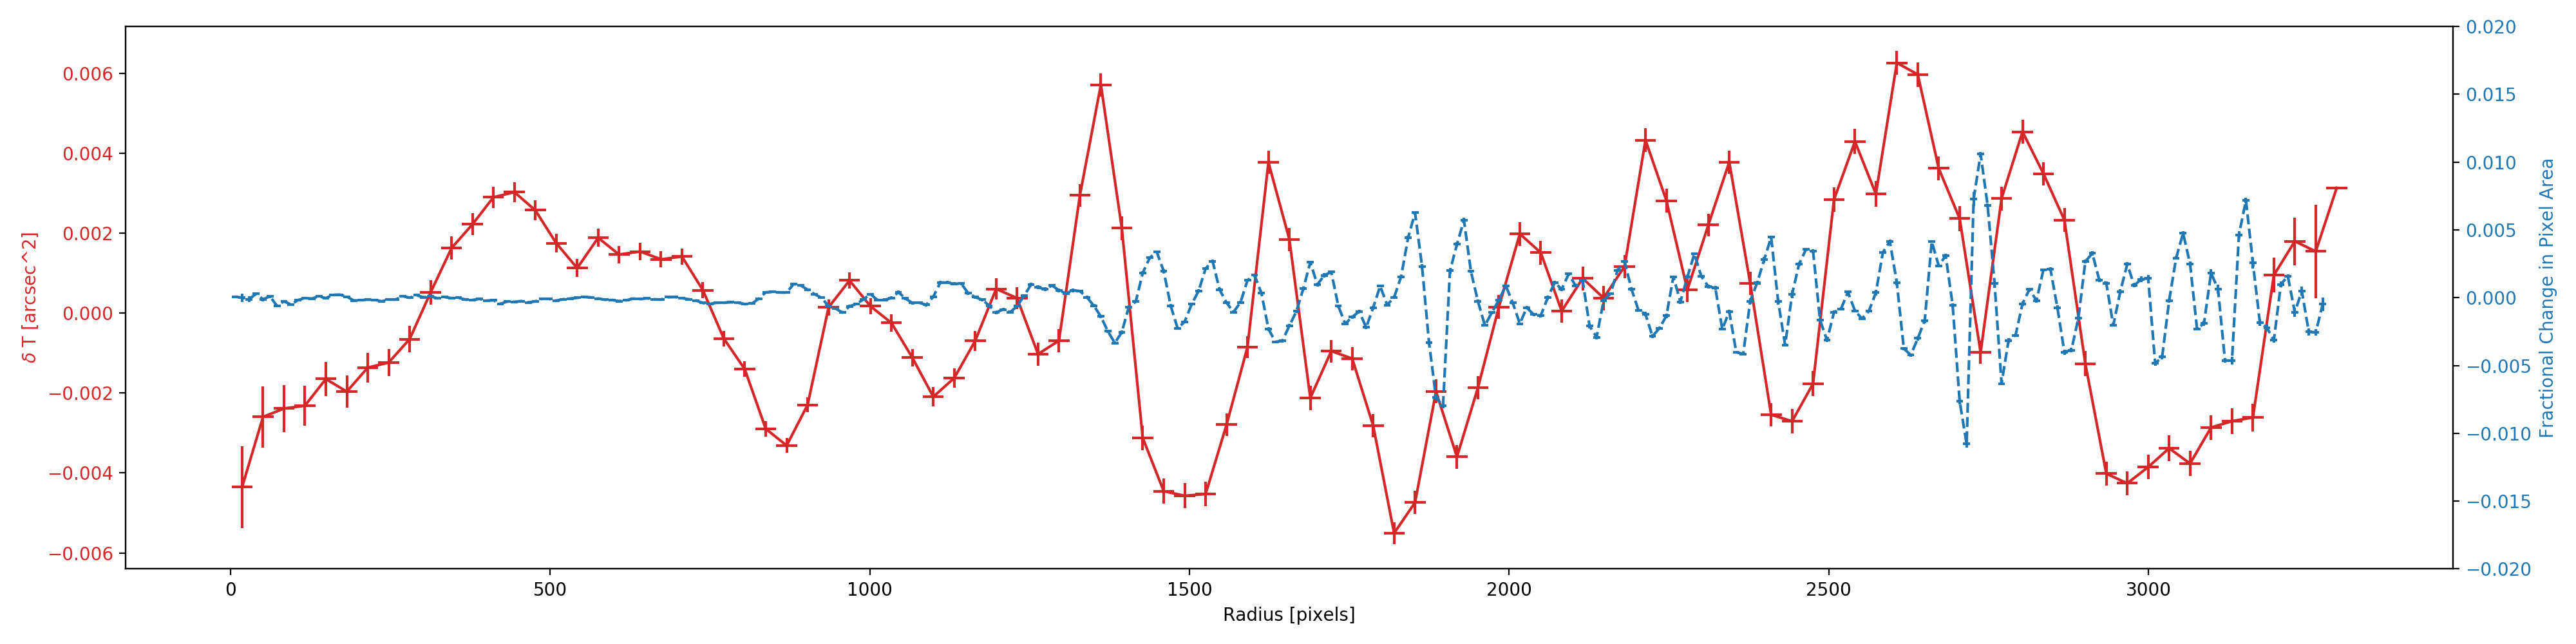

In [14]:
od = mkDeltaTvsRplot(ccdname='S29',band='i',table=tableY3)
mkPlots(od)

In [15]:
odr = mkDeltaTvsRplot(ccdname='S29',band='r',table=tableY3)
odz = mkDeltaTvsRplot(ccdname='S29',band='z',table=tableY3)


<IPython.core.display.Javascript object>


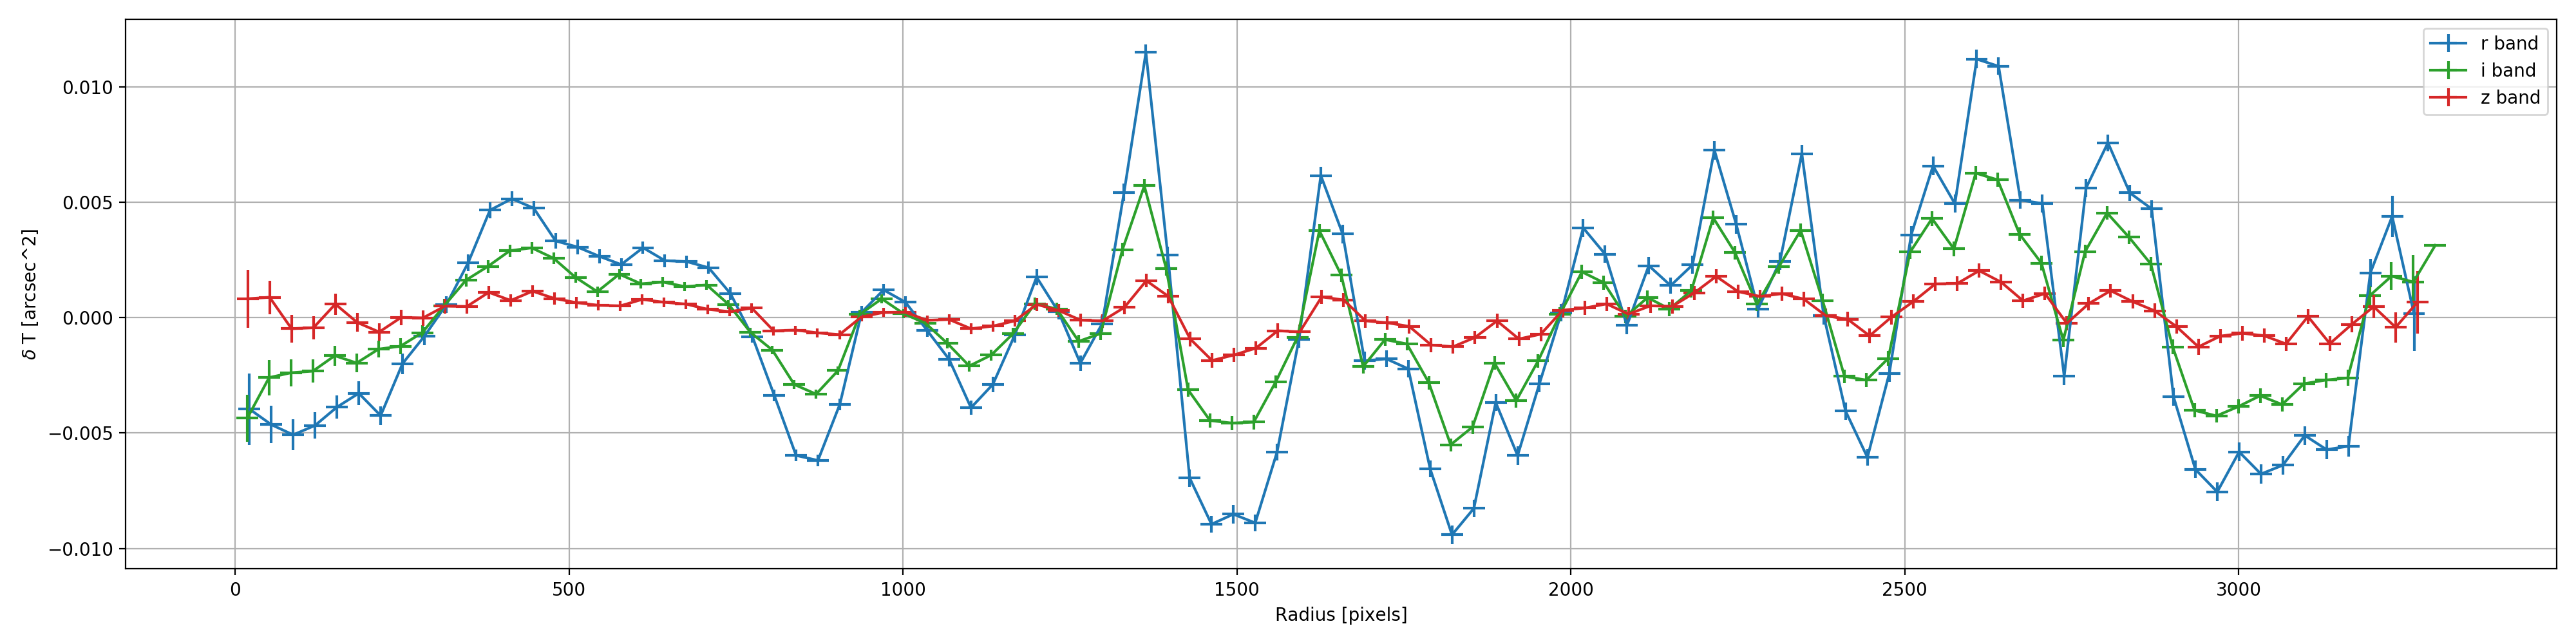

In [16]:
# plot r,i,z bands

f, ax = plt.subplots(figsize=(20,5))

[x,y,xe,ye] = odr['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'r band',color='tab:blue')
[x,y,xe,ye] = od['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'i band',color='tab:green')
[x,y,xe,ye] = odz['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'z band',color='tab:red')


ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('$\delta$ T [arcsec^2]')
ax.legend()
ax.grid()

f.tight_layout()

In [10]:
od_S3_r = mkDeltaTvsRplot(ccdname='S3',band='r',table=tableY3)
od_S3_i = mkDeltaTvsRplot(ccdname='S3',band='i',table=tableY3)
od_S3_z = mkDeltaTvsRplot(ccdname='S3',band='z',table=tableY3)


<IPython.core.display.Javascript object>


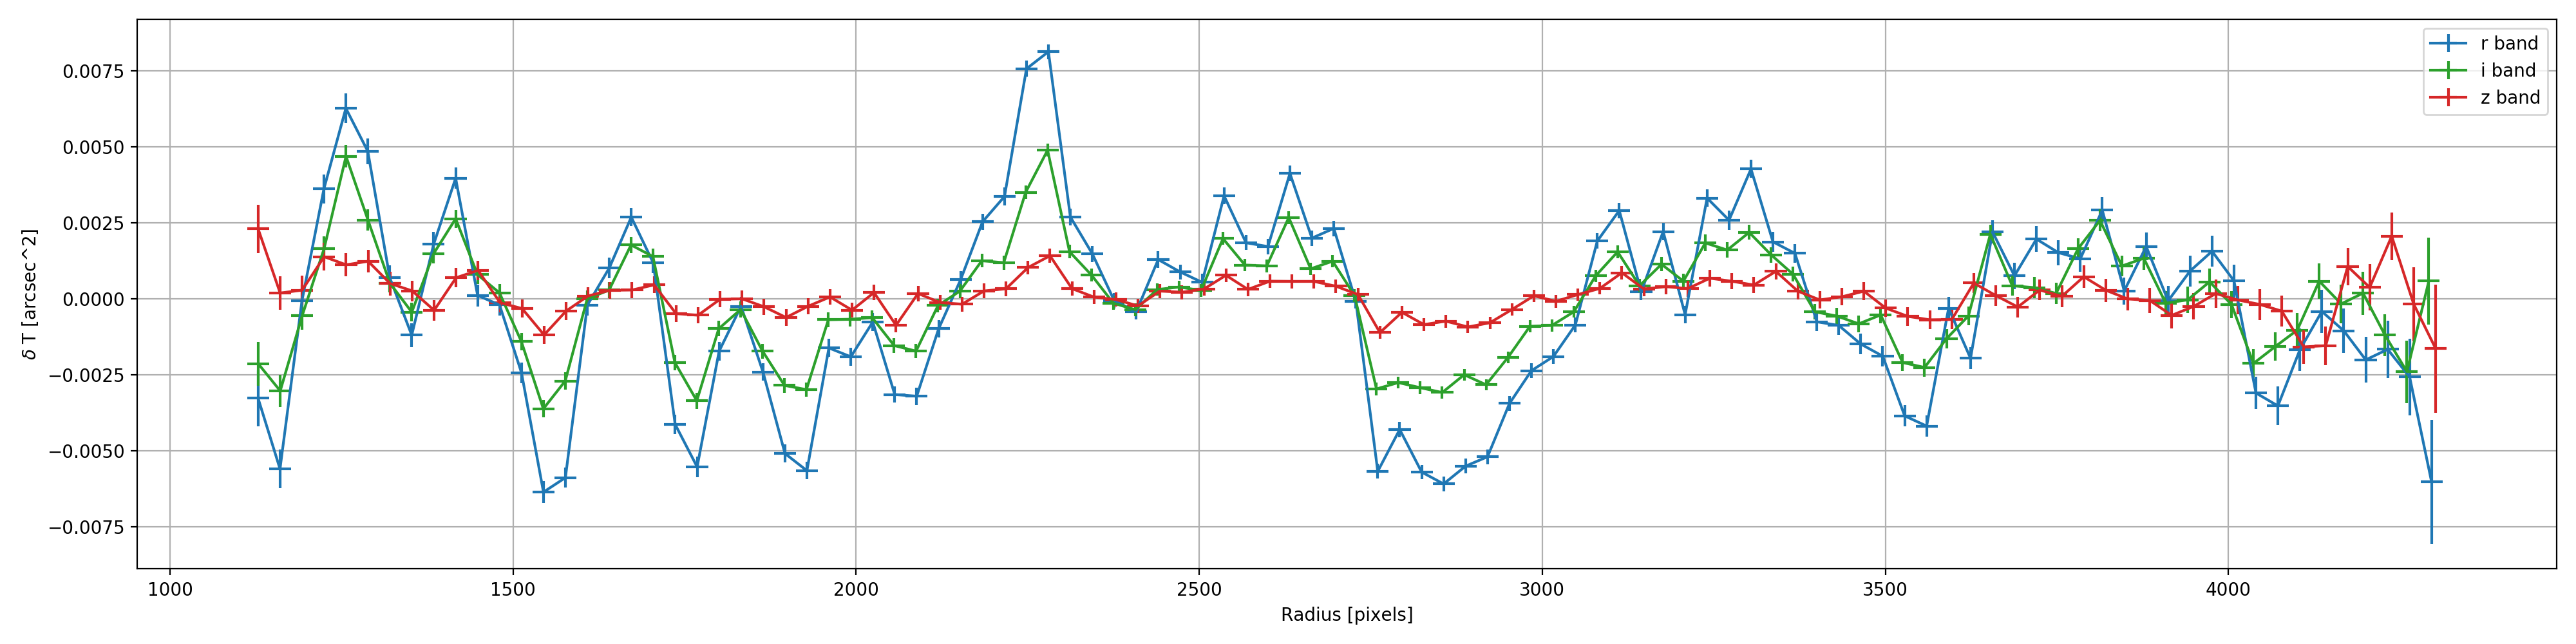

In [17]:
# plot r,i,z bands

f, ax = plt.subplots(figsize=(20,5))

[x,y,xe,ye] = od_S3_r['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'r band',color='tab:blue')
[x,y,xe,ye] = od_S3_i['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'i band',color='tab:green')
[x,y,xe,ye] = od_S3_z['deltaTplot']
ax.errorbar(x,y, xerr=xe, yerr=ye,label = 'z band',color='tab:red')

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('$\delta$ T [arcsec^2]')
ax.legend()
ax.grid()

f.tight_layout()

In [ ]:
# plot deltaT for all r band images
f, ax = plt.subplots(1,1,figsize=(8,8))
ngrid = 500
cset = ax.hexbin(x_Y129, y_Y129, rAD_Y129, gridsize=ngrid, cmap='inferno')

# Development Code

In [55]:
# get the Y1 datatable
tableY1 = Table.read("/u/ec/roodman/kipacdisk/PIFF/psf_y1a1-v13.fits",format='fits')
print(tableY1.columns)

# get the Y3 datatable
#tableY3 = Table.read("/u/ec/roodman/kipacdisk/PIFF/psf_y3a1-v29.fits", format='fits')
#print(tableY3.columns)



<TableColumns names=('ra','dec','x','y','obs_e1','obs_e2','obs_T','piff_e1','piff_e2','piff_T','mag','fov_x','fov_y','exp','ccd','band','tiling')>


In [56]:
d = yaml.safe_load(open("/nfs/slac/g/ki/ki06/roodman/Pixmappy/Y6A1_ASTROMETRY/astrorings4.yaml",'r'))

pickle_file = "/u/ec/roodman/kipacdisk/PIFF/pixmappy_pix_area.pkl"
[fov_x_in,fov_y_in,pix_area_in] = pickle.load(open(pickle_file, "rb"))

print(dinfo.infoDict.keys())

print(pix_area_in.keys())

odict_keys(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'FS1', 'FS2', 'FS3', 'FS4', 'FN1', 'FN2', 'FN3', 'FN4'])
dict_keys([25, 26, 27, 28, 29, 30, 31, 19, 20, 21, 22, 23, 24, 13, 14, 15, 16, 17, 18, 8, 9, 10, 11, 12, 4, 5, 6, 7, 1, 2, 3, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62])


In [26]:
# select the center of the ring values for CCD S29 aka 1  
tableS29 = d['S29']

print(tableS29['XCenter'], tableS29['YCenter'])
print(tableS29['Values'])

1004.08 3196.22
[-0.0006923158367711987, -0.0003751539329385155, 0.004212166319500803, 0.002311531056503301, 0.0013739930809331087, 0.00703460519601736, 0.006982420205470284, 0.004720490913619885, 0.001230870125537895, 0.00021627731384037075, -8.123471450718312e-05, 0.0006372959395296643, -0.001354305187341575, -0.002339988780724051, -0.0026615616684482033, -0.001075401439115244, -0.0003697780786142228, -0.0014366503230900075, -0.0019445298941826534, -0.003701493870433937, -0.004468793347198359, -0.006487716765076518, -0.006835490512336891, -0.0061774663266293255, -0.007121261846192672, -0.007252307428693674, -0.004662728319484365, -0.005457512263868808, -0.006234355488086586, -0.008215954339318546, -0.00800383859760501, -0.008446624146659632, -0.00877785897046024, -0.007261086788715975, -0.005233328425872888, -0.003597145758725369, -0.0014556614687266454, -0.0006200508235224656, 0.0004012547176471293, 0.00037477983794070857, 0.0011578858469132028, 0.0014208637767173565, 0.001703490369

In [27]:
## Converting the position of the center of the tree rings from pixel space to fov space
# units is 0.263 arcsec/pixel and 0.015 mm/pixel
factor = 0.263 / 0.015

# ix,iy are pixel number (probably starts at 1 not 0)
# getPosition returns the focal plane x,y position in [mm]
fov_x_treecenter, fov_y_treecenter = dinfo.getPosition("S29", 1004.08, 3196.22)

# now we calculate the x,y position in arcsec
fov_x_treecenter = fov_x_treecenter * factor
fov_y_treecenter = fov_y_treecenter * factor

# Calculate radius and deltaT

In [28]:
def T_convert(s):
    return 2 * s**2

In [29]:
# for Y1, find distance from tree ring center to star
# also convert from size,psf_size to T, where T=Ixx+Iyy using T_convert function
# 0.263 is the pixel scale in arcsec/pixel, so radius is in units of [pixel] and deltaT is in units of [arcsec^2]

radius_S29_Y1 = np.sqrt( (S29_Y1['fov_y'] - fov_y_treecenter)**2 + (S29_Y1['fov_x'] - fov_x_treecenter)**2 ) / 0.263
deltaT_S29_Y1 = (T_convert(S29_Y1['size'])-T_convert(S29_Y1['psf_size'])) 
fov_x_S29_Y1 = S29_Y1['fov_x']/0.263
fov_y_S29_Y1 = S29_Y1['fov_y']/0.263

In [14]:
S29_Y3 = tableY3[(tableY3['ccd']==1)]
S29_Y3_iband = S29_Y3[(S29_Y3['band']=='i')]
S29_Y3_rband = S29_Y3[(S29_Y3['band']=='r')]
S29_Y3_zband = S29_Y3[(S29_Y3['band']=='z')]

In [30]:
# for Y3, find distance from tree ring center to star
# also calculate deltaT where T=Ixx+Iyy using T_convert function
# 0.263 is the pixel scale in arcsec/pixel, so radius is in units of [pixel] and deltaT is in units of [arcsec^2]

radius_S29_Y3 = np.sqrt( (S29_Y3['fov_y'] - fov_y_treecenter)**2 + (S29_Y3['fov_x'] - fov_x_treecenter)**2 ) / 0.263
deltaT_S29_Y3 = (S29_Y3['obs_T']-S29_Y3['piff_T']) 
fov_x_Y329 = S29_Y3['fov_x']/0.263
fov_y_Y329 = S29_Y3['fov_y']/0.263

In [31]:
## Values for fov_x, fov_y, and pix_area from CCD29 in the pickle file.
iCCD = 1
ixs = fov_x_in[iCCD]
iys = fov_y_in[iCCD]
ipa = pix_area_in[iCCD]
iny,inx = ipa.shape
ixlist = []
iylist = []
ipalist = []
for iy in range(iny):
    for ix in range(inx):
        ipalist.append(ipa[iy,ix])
        ixlist.append( (ixs[iy,ix]+ixs[iy,ix+1])/2. )
        iylist.append( (iys[iy,ix]+iys[iy+1,ix])/2. )
        
ixlist_array = np.array(ixlist)
iylist_array = np.array(iylist)
ipalist_array = np.array(ipalist)

In [32]:
# pixel size
radius_pixmap = np.sqrt( (iylist_array - fov_y_treecenter)**2 + (ixlist_array - fov_x_treecenter)**2 ) / 0.263
pixelarea_pixmap = ipalist_array / 0.263**2
fov_x_pixmap = iylist_array/0.263
fov_y_pixmap = ixlist_array/0.263


# i band 

<IPython.core.display.Javascript object>


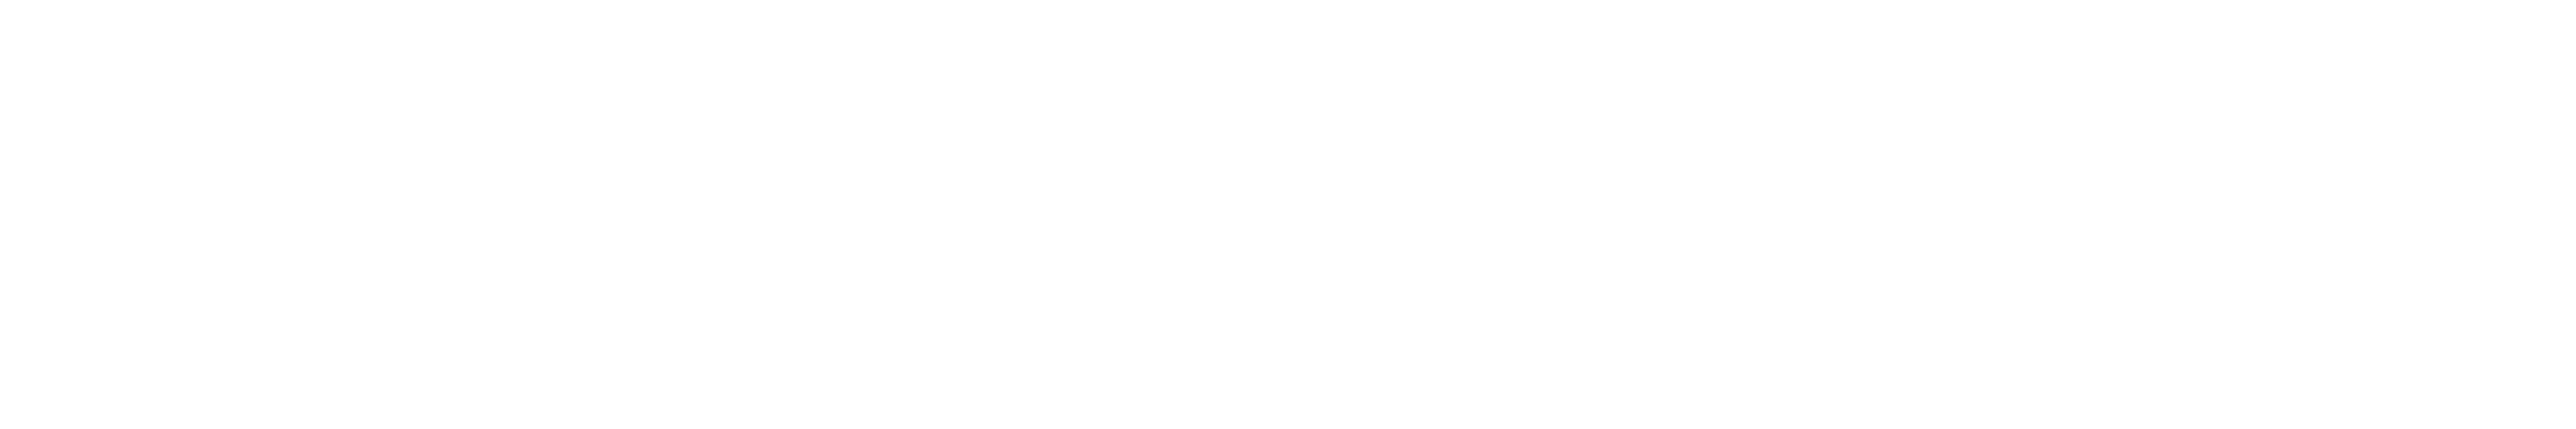

In [33]:
f, ax = plt.subplots(figsize=(30,5))

nbins = 300
xmax = 3500.

r = radius_S29_Y1[iS29_Y1_iband]
dT = deltaT_S29_Y1[iS29_Y1_iband]
ixvalY1, iyvalY1, ixerrY1, iyerrY1 = mkProfile(r, dT, nx=nbins, xmin=0,xmax=xmax, ymin=np.min(dT),ymax=np.max(dT), retPlot=False)
ax.errorbar(ixvalY1, iyvalY1, xerr=ixerrY1, yerr=iyerrY1,label = 'Y1')

r = radius_S29_Y3[iS29_Y3_iband]
dT = deltaT_S29_Y3[iS29_Y3_iband]
ixvalY3, iyvalY3, ixerrY3, iyerrY3 = mkProfile(r, dT, nx=nbins, xmin=0,xmax=xmax, ymin=np.min(dT),ymax=np.max(dT), retPlot=False)
ax.errorbar(ixvalY3, iyvalY3, xerr=ixerrY3, yerr=iyerrY3,label = 'Y3')
    
ax.legend(loc=3, fontsize=8)
ax.grid()
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('$\delta$ T [pixel^2]')
f.tight_layout()

# pixel size  vs radius

<IPython.core.display.Javascript object>


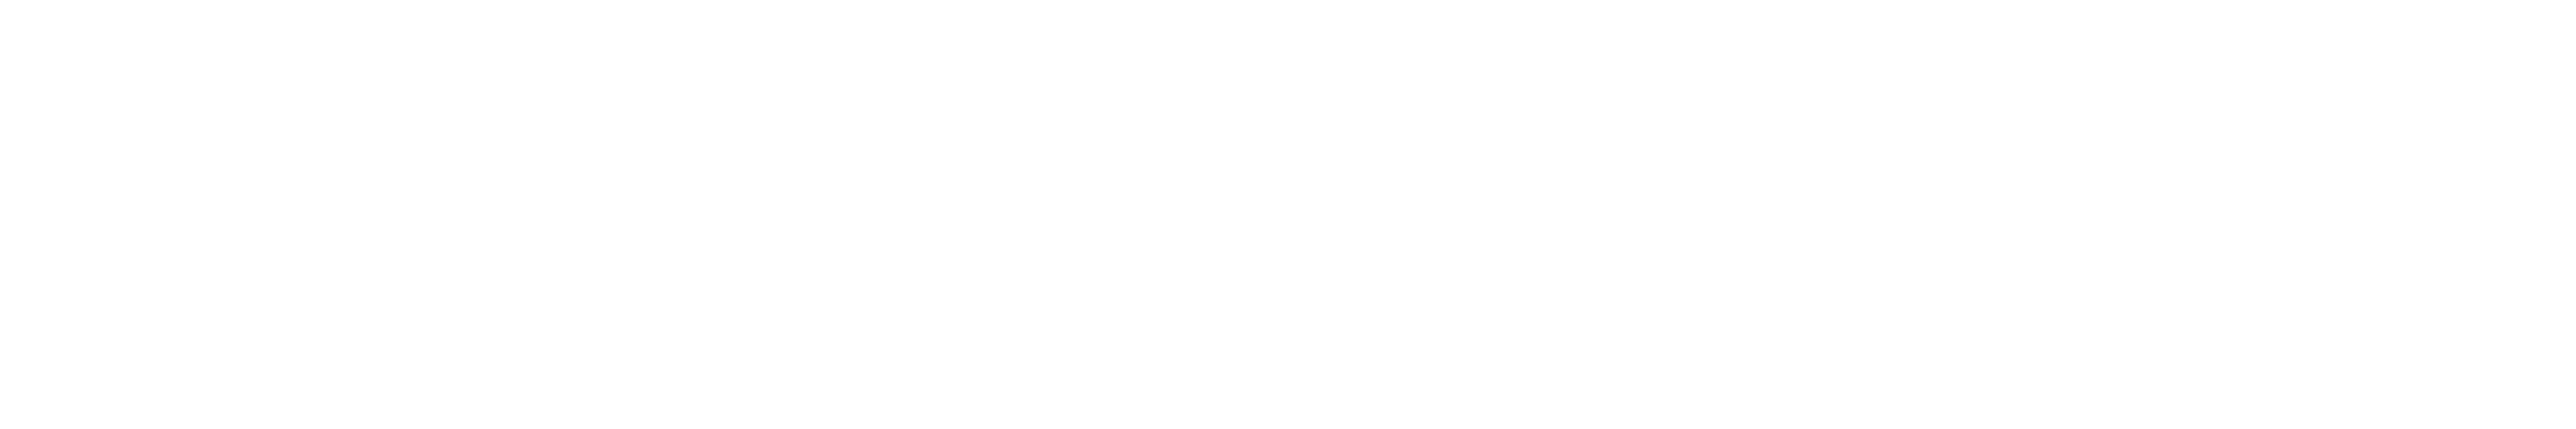

In [34]:
# plot pixelsize residual vs. radius

delta_pixelsize = (pixelarea_pixmap - np.mean(pixelarea_pixmap))/pixelarea_pixmap
xpval2, ypval2, xperr2, yperr2 = mkProfile(radius_pixmap, delta_pixelsize, nx=300, xmin=0., xmax=3500.,ymin=np.min(delta_pixelsize),ymax=np.max(delta_pixelsize),retPlot=False)

f,ax = plt.subplots(figsize=(30,5))
ax.errorbar(xpval2, ypval2, xerr=xperr2, yerr=yperr2, color='k', ls='--', label = 'Pixmappy bins size 250')

ax.legend(loc=3, fontsize=8)
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Fractional Change in Pixel Area')
ax.grid(True)
f.tight_layout()


<IPython.core.display.Javascript object>


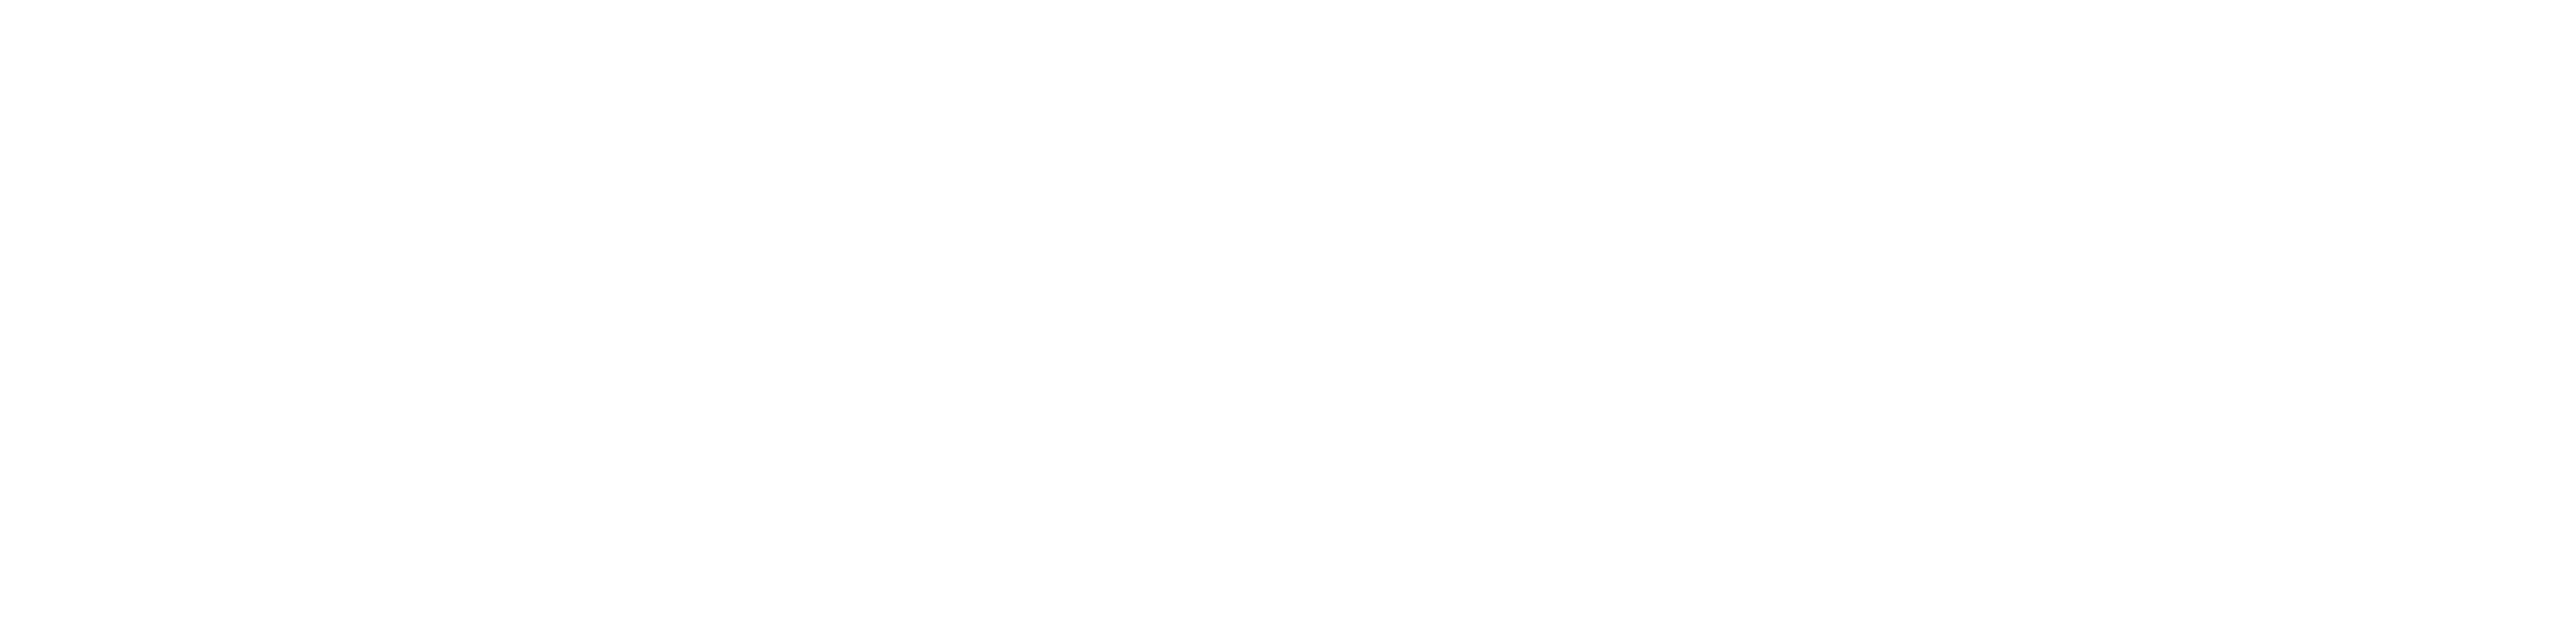

In [35]:
# plot Y3 and pixelsize together...
f, ax = plt.subplots(figsize=(20,5))

nbins = 300
xmax = 3500.


r = radius_S29_Y3[iS29_Y3_iband]
dT = deltaT_S29_Y3[iS29_Y3_iband]
ixvalY3, iyvalY3, ixerrY3, iyerrY3 = mkProfile(r, dT, nx=nbins, xmin=0,xmax=xmax, ymin=np.min(dT),ymax=np.max(dT), retPlot=False)
ax.errorbar(ixvalY3, iyvalY3, xerr=ixerrY3, yerr=iyerrY3,label = 'deltaT Y3',color='tab:red')
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('$\delta$ T [arcsec^2]',color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')

axr = ax.twinx()
axr.errorbar(xpval2, ypval2, xerr=xperr2, yerr=yperr2, color='tab:blue', ls='--', label = 'Pixmappy bins size 250')
axr.set_ylabel('Fractional Change in Pixel Area',color='tab:blue')
axr.set_ylim(-0.02,0.02)
axr.tick_params(axis='y',labelcolor='tab:blue')

# astrometric shift
#values = d['S29']['Values']
#n = len(values)
#radii = d['S29']['ArgStart'] + d['S29']['ArgStep']*np.arange(n) 
#axr.scatter(radii,values,marker='.',s=0.4)
#axr.set_ylim(-0.5,0.5)

f.tight_layout()




<IPython.core.display.Javascript object>


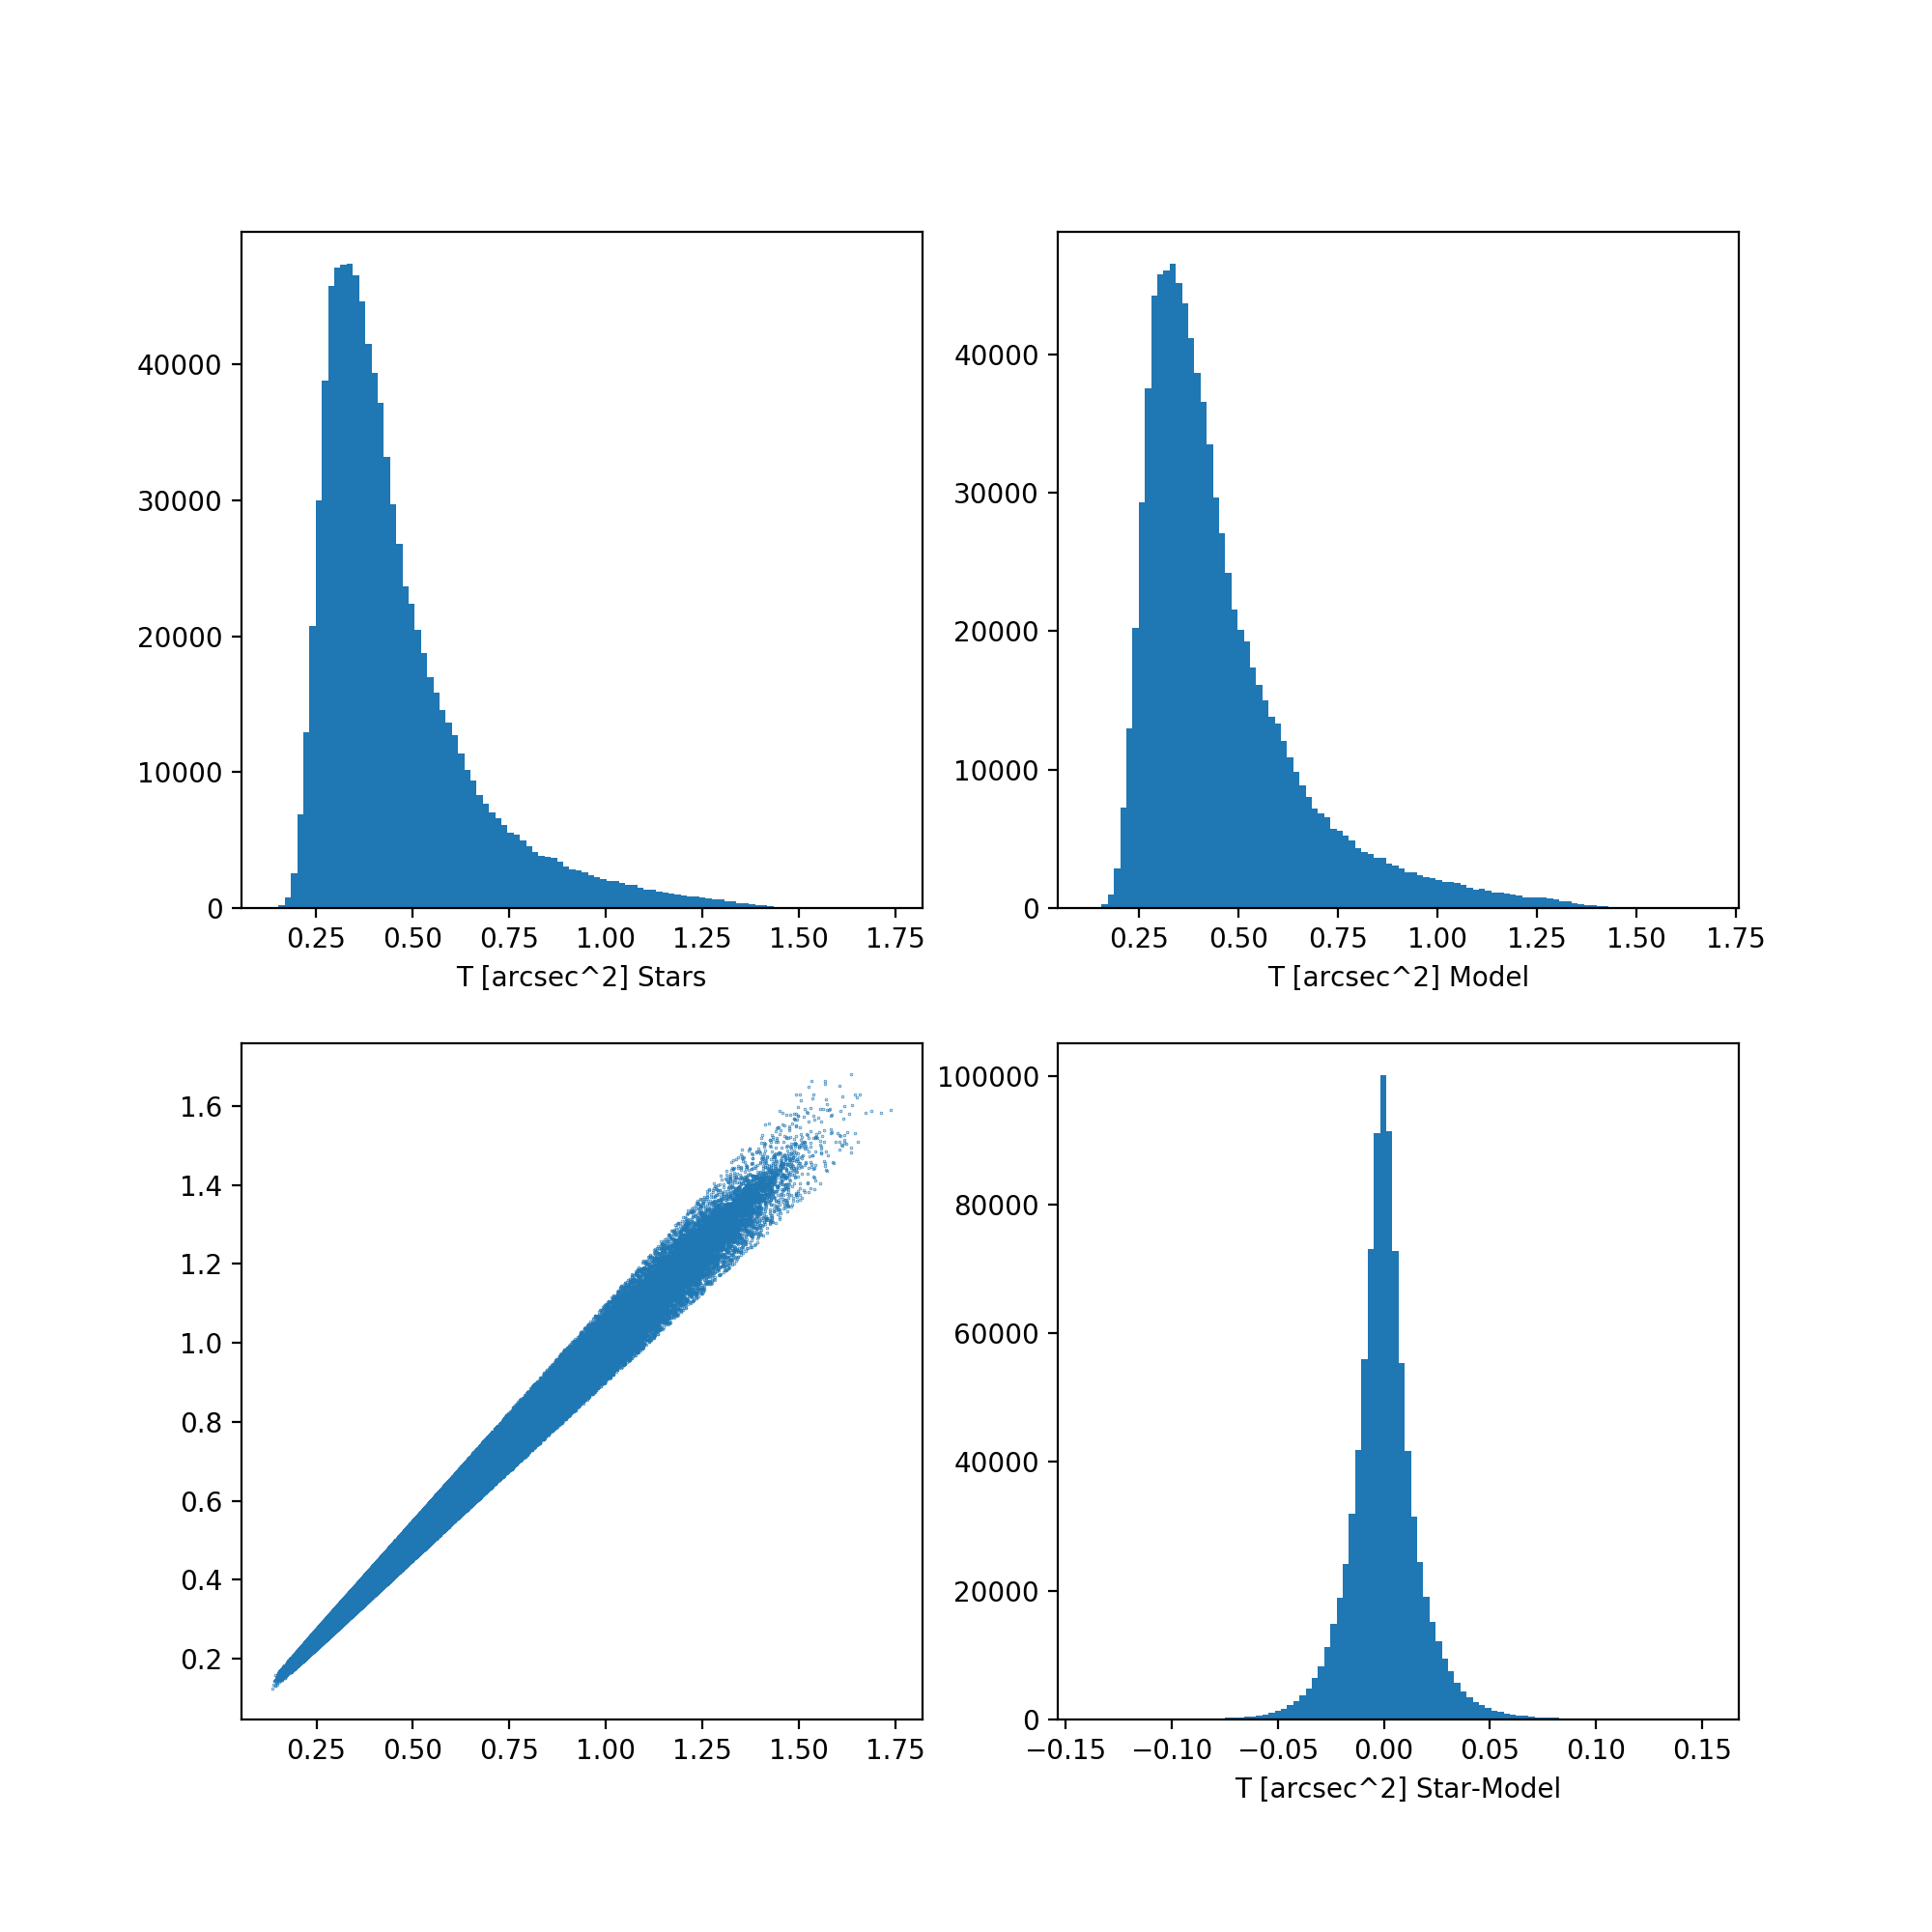

Text(0.5, 0, 'T [arcsec^2] Star-Model')

In [37]:
# other plots
f,axf = plt.subplots(2,2,figsize=(10,10))
ax = axf.flatten()

h = ax[0].hist(S29_Y3['obs_T'],bins=100)
ax[0].set_xlabel('T [arcsec^2] Stars')
h = ax[1].hist(S29_Y3['piff_T'],bins=100)
ax[1].set_xlabel('T [arcsec^2] Model')

h = ax[2].scatter(S29_Y3['obs_T'],S29_Y3['piff_T'],s=0.05)
h = ax[3].hist(S29_Y3['obs_T']-S29_Y3['piff_T'],bins=100)
ax[3].set_xlabel('T [arcsec^2] Star-Model')



# T vs. Exposure number

In [9]:
x,y,ex,ey = mkProfile(S29_Y3_iband['exp'],S29_Y3_iband['obs_T'],nx=400000, xmin=200000.0-0.5,xmax=600000.0-0.5,ymin=0.0,ymax=4.0,retPlot=False)

In [13]:
# how many i band images?
isthere = (y>0.)
x_isthere = x[isthere]
print(x_isthere)
print(len(x_isthere))

[228724. 228728. 228730. ... 516790. 516794. 516796.]
7179


In [16]:
xz,yz,exz,eyz = mkProfile(S29_Y3_zband['exp'],S29_Y3_zband['obs_T'],nx=400000, xmin=200000.0-0.5,xmax=600000.0-0.5,ymin=0.0,ymax=4.0,retPlot=False)
xr,yr,exr,eyr = mkProfile(S29_Y3_rband['exp'],S29_Y3_rband['obs_T'],nx=400000, xmin=200000.0-0.5,xmax=600000.0-0.5,ymin=0.0,ymax=4.0,retPlot=False)

In [17]:
# how many r,z band images?
istherez = (yz>0.)
x_istherez = xz[istherez]
print(x_istherez)
print(len(x_istherez))

istherer = (yr>0.)
x_istherer = xr[istherer]
print(x_istherer)
print(len(x_istherer))

[226650. 226651. 226652. ... 516834. 516835. 516836.]
7573
[228723. 228726. 228727. ... 516789. 516793. 516797.]
7119


<IPython.core.display.Javascript object>


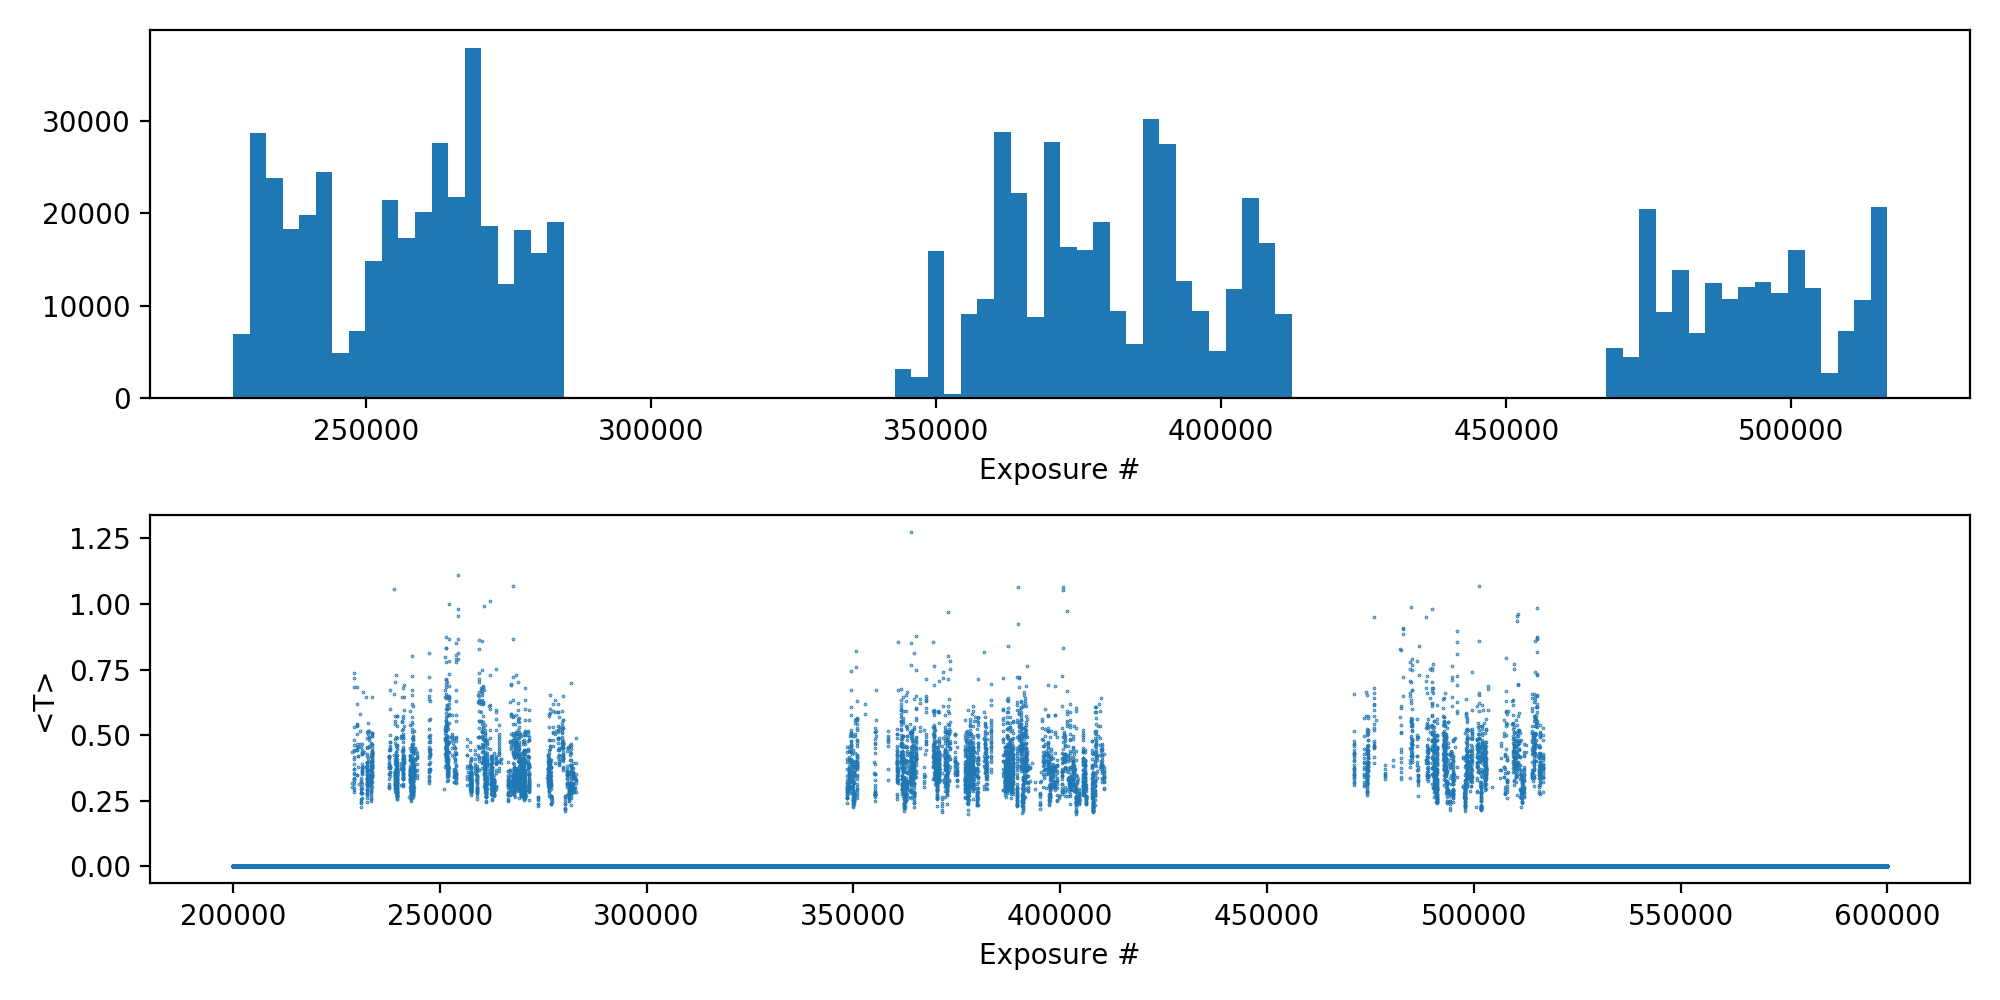

In [39]:
# other plots
f,axf = plt.subplots(2,1,figsize=(10,5))
ax = axf.flatten()

h = ax[0].hist(S29_Y3['exp'],bins=100)
ax[0].set_xlabel('Exposure #')
h = ax[1].scatter(x,y,s=0.1)
ax[1].set_xlabel('Exposure #')
ax[1].set_ylabel('<T>')

f.tight_layout()


In [40]:
des_fwhm = pd.read_pickle('des_fwhm.pkl')
print(des_fwhm)

         expid      fwhm  qc_fwhm
24746   179838  1.279838      NaN
24747   179839  1.363566      NaN
24748   179840  1.368055      NaN
24749   179841  1.231741      NaN
24750   179842  1.310569      NaN
...        ...       ...      ...
249475  540912  2.070894     2.10
249476  540913  2.002053     2.03
249477  540914  1.791285     1.79
249480  540917  2.200123     2.33
249481  540918  2.240463     2.39

[222594 rows x 3 columns]


In [41]:
ix = x.astype(int)
data_dict = {'expid':ix,'meanT':y}
des_T = pd.DataFrame(data_dict)
print(des_T)

         expid  meanT
0       200000    0.0
1       200001    0.0
2       200002    0.0
3       200003    0.0
4       200004    0.0
...        ...    ...
399995  599995    0.0
399996  599996    0.0
399997  599997    0.0
399998  599998    0.0
399999  599999    0.0

[400000 rows x 2 columns]


In [42]:
des_fwhmT = des_T.merge(des_fwhm,on='expid')
ok = (des_fwhmT.meanT>0.) & (des_fwhmT.fwhm>0.)
des_fwhmT = des_fwhmT[ok]
print(des_fwhmT)

         expid     meanT      fwhm  qc_fwhm
16819   228724  0.434234  1.033544      NaN
16823   228728  0.316621  0.815394      NaN
16825   228730  0.302692  0.811400      NaN
17076   229296  0.315584  0.836271     0.85
17079   229299  0.326476  0.875039     0.88
...        ...       ...       ...      ...
193568  516779  0.406121  0.964463     0.93
193570  516781  0.420119  1.007792     0.97
193579  516790  0.385628  0.949908     0.92
193583  516794  0.373787  0.980211     0.93
193585  516796  0.373189  0.948262     0.90

[7179 rows x 4 columns]


<IPython.core.display.Javascript object>


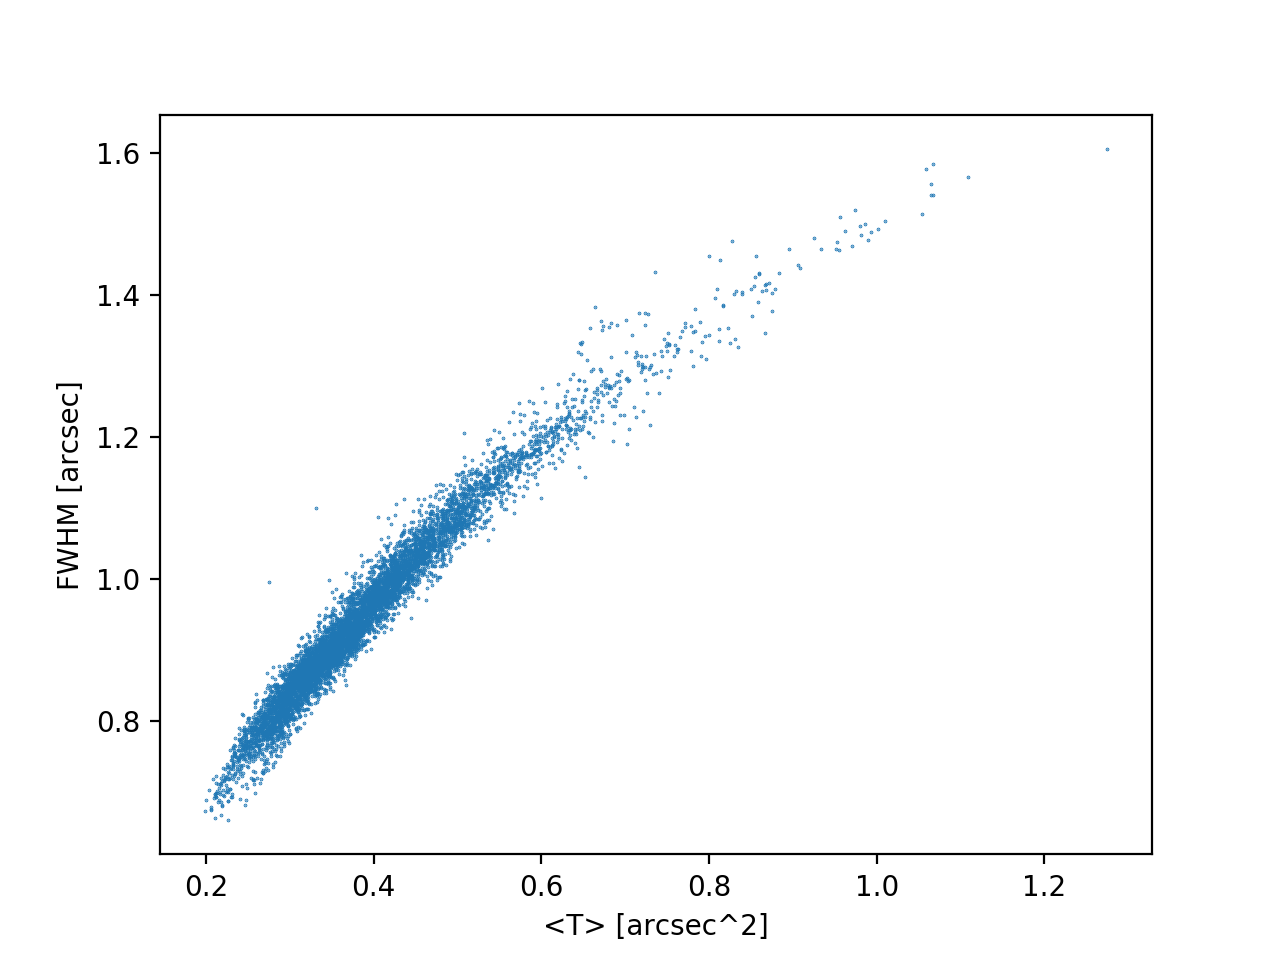

Text(0, 0.5, 'FWHM [arcsec]')

In [43]:
f,ax = plt.subplots(1,1)
ax.scatter(des_fwhmT.meanT,des_fwhmT.fwhm,s=0.1)
ax.set_xlabel('<T> [arcsec^2]')
ax.set_ylabel('FWHM [arcsec]')

# Moment definitions

$$ I_{xx} = \frac{ \sum_i I_i * x^2_i * w_i }{\sum_i I_i * w_i} $$

$$ I_{yy} = \frac{ \sum_i I_i * y^2_i * w_i }{\sum_i I_i * w_i} $$

$$ I_{xy} = \frac{ \sum_i I_i * x_i * y_i *  w_i }{\sum_i I_i * w_i} $$

$$ T = I_{xx} + I_{yy} $$

$$ e_1 =  I_{xx} - I_{yy} $$

$$ e_2 =  2 * I_{xy} $$

# Conversion between T and $\sigma$

for a 2-d Gaussian $ I(x,y) \sim \exp{-\frac{x^2+y^2}{2\sigma^2}}$ , $I_{xx} = \sigma^2$, so $T = 2\sigma^2$ 

then use that ${\rm FWHM} = 2\sqrt{2\log{2}} \sigma$

to get $ {\rm FWHM} = 2.355 \sqrt{T/2} $


<IPython.core.display.Javascript object>


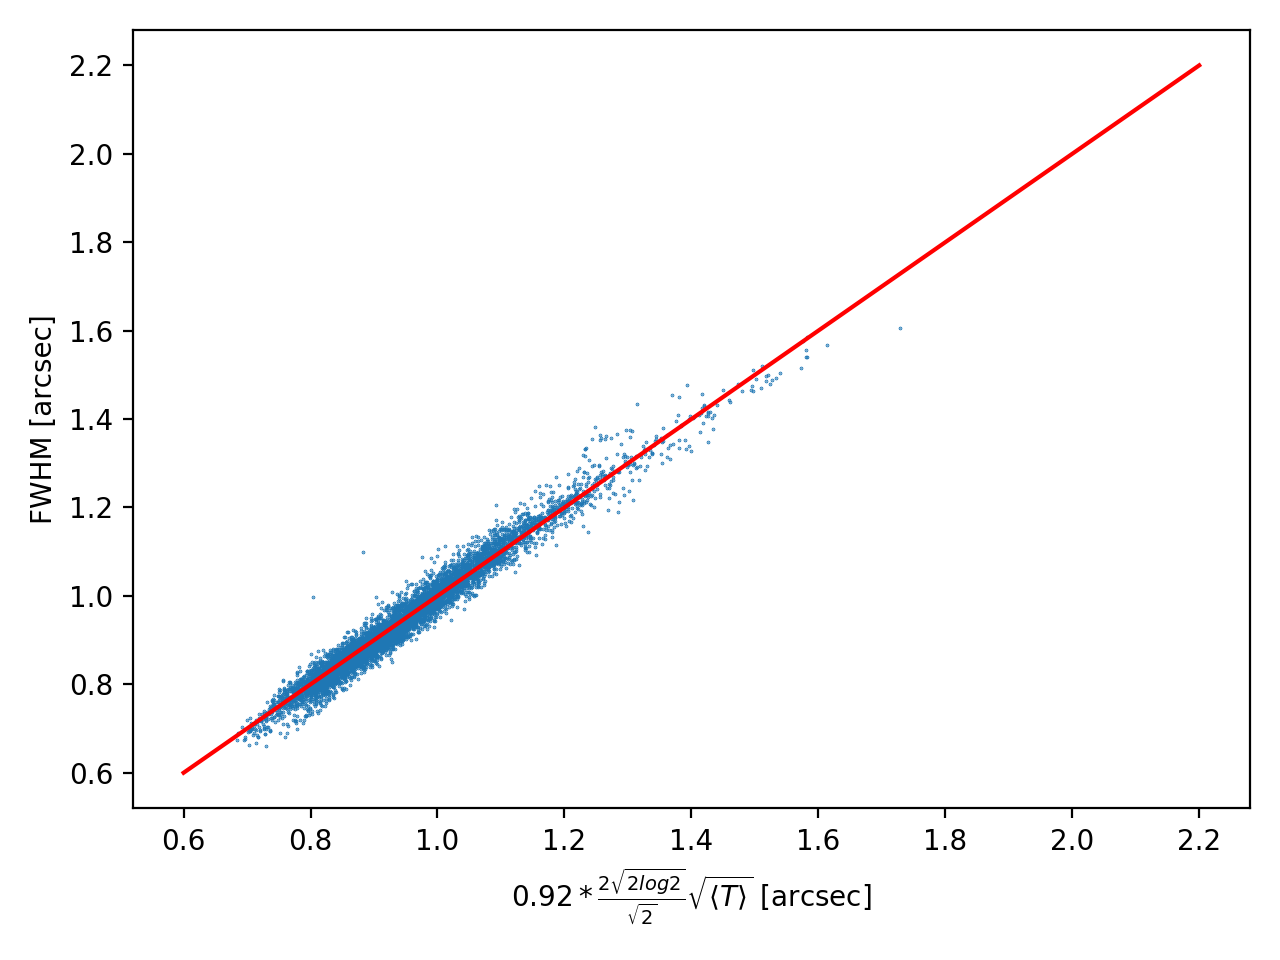

In [44]:
f,ax = plt.subplots(1,1)
fudge = 0.92
factor = fudge*2.*np.sqrt(2.*np.log(2.))/np.sqrt(2.)
ax.scatter(factor*np.sqrt(des_fwhmT.meanT),des_fwhmT.fwhm,s=0.1)
ax.set_xlabel(r"$0.92 * \frac{2\sqrt{2log2}}{\sqrt{2}} \sqrt{\langle T \rangle}$ [arcsec]")
ax.set_ylabel('FWHM [arcsec]')

ax.plot([0.6,2.2], [0.6,2.2], 'k-', color = 'r')

f.tight_layout()
